# Deep Open Classifier Implementation
This is a pseudo implementation of a Deep Open Classifier (more of an open classifier) which manages to provide rejection or acceptance of classifications made on new data based on previously computed class thresholds.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import norm as dist_model
from numpy import max, round, where, argwhere
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from utils import compute_threshold, fit_distribution_single_class

import warnings
warnings.filterwarnings('ignore')

# Generate Fake Data
We create a fake dataset with three classes represented as blobs defined by two features, $x_1$ and $x_2$

,x1,x2,class
648,2.353294,5.298470,1
111,2.364872,5.360115,1
68,2.085702,6.488032,1
19,6.593581,-10.156938,0
617,2.613262,4.483215,1


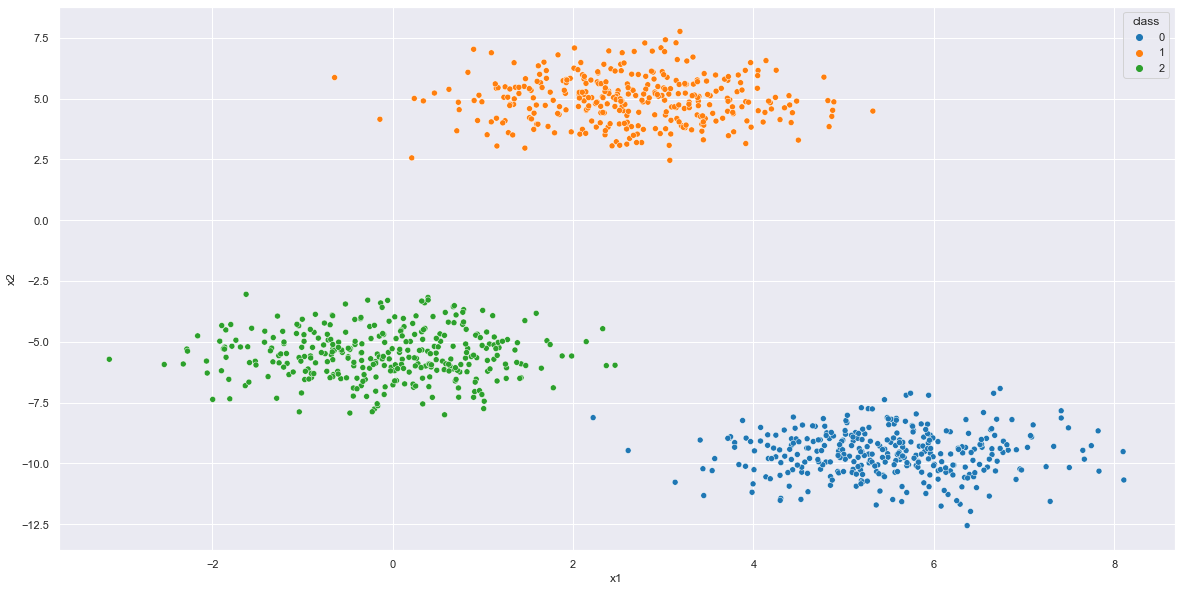

In [3]:
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=10)
df = pd.DataFrame(X, columns=['x1', 'x2'])
df['class'] = y
sns.set()
fig, axs = plt.subplots(figsize=(20, 10))
sns.scatterplot(df['x1'], df['x2'], hue=df['class'], palette='tab10')
df.sample(5)

We now filter out class 2 and we will treat it as an unknown (new) class that our model will not see during training. We will end up with only 1 and 0 labels.

,x1,x2,class
431,4.302659,-11.442319,0
976,4.713613,-9.845820,0
525,-0.142097,4.154699,1
179,6.310780,-10.971784,0
223,5.691924,-9.476412,0


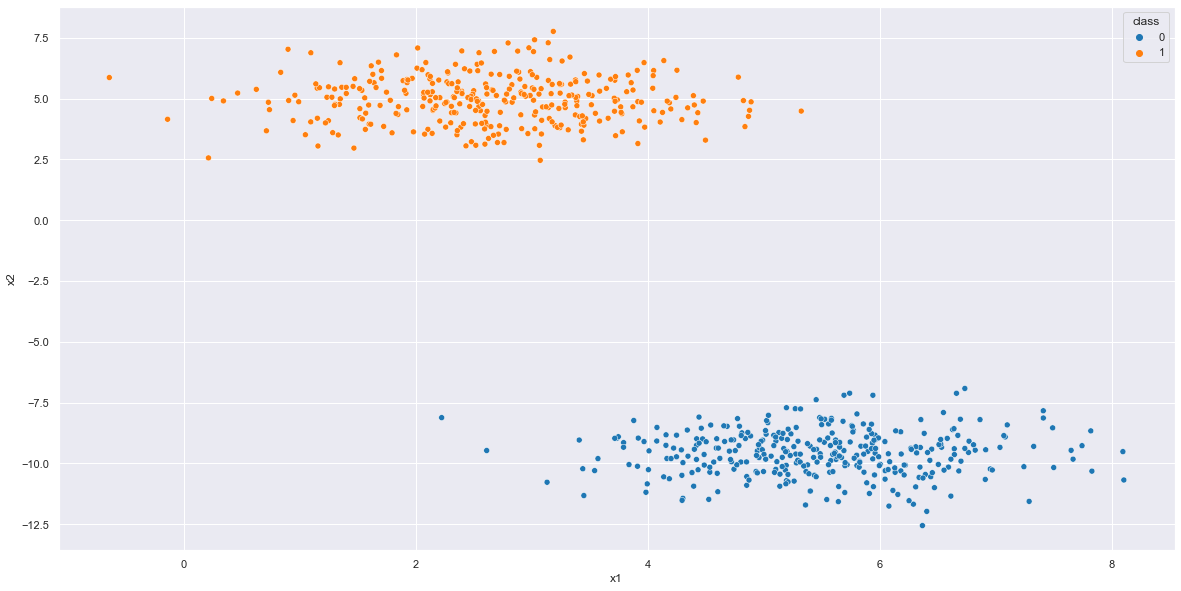

In [4]:
df_filter = df[df['class'] != 2]
fig, axs = plt.subplots(figsize=(20, 10))
sns.scatterplot(df_filter['x1'], df_filter['x2'], hue=df_filter['class'], palette='tab10')
df_filter.sample(5)

# Train the Classifier
We will train a model to classify N-1 classes so that one of the prvious blobs acts as the unknown data, is our case all data points labeled as **class 2** will act as new unseen data.

In other words, our model will only train with the above dataset.

In [5]:
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(df_filter[['x1', 'x2']], df_filter['class'])

OneVsRestClassifier(estimator=LogisticRegression())

# Use the Model for Predictions
Using our model, **perfectly trained for classes 1 and 0**, we now **predict on the entire dataset** to see how the model classifies what initially was supposed to be class 2.

In [6]:
df['prediction'] = clf.predict(df[['x1', 'x2']])
df['color'] = where(df['prediction'] == 0, 'blue', 'green')

Even though the lower left blob does not clearly belong to any of the two classes, the model fits it within one of the two because **it doen't know anything else than classes 0 and 1**, here we face the **closed world assumption** problem. We trained our model under the assumption that data points can only belong to classes 0 and 1.

Ideally we would like our model to identify new data points that do not belong to any of the trained classes as **unknown**.

<AxesSubplot:xlabel='x1', ylabel='x2'>

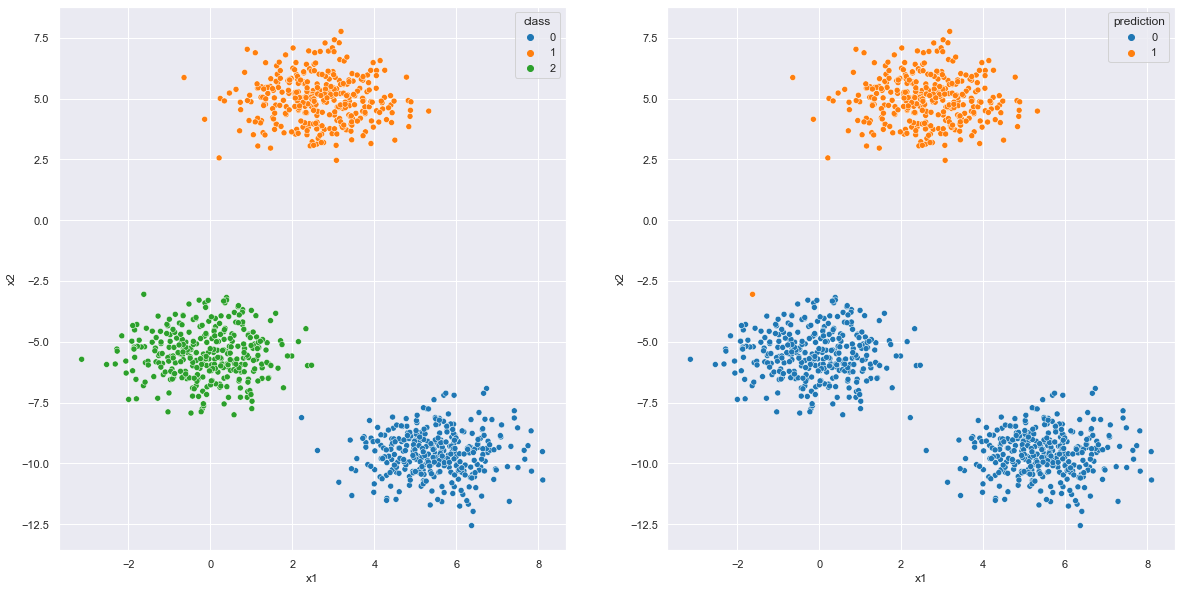

In [7]:
fix, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.scatterplot(df["x1"], df["x2"], hue=df["class"], palette="tab10", ax=axs[0])
sns.scatterplot(
    df["x1"],
    df["x2"],
    hue=df["prediction"],
    palette="tab10",
    ax=axs[1],
)

# Deep Open Classifier Implementation
We now implement the rejection capabilities to our model using the strategy proposed in https://arxiv.org/abs/1709.08716

## Compute the probability for the two classes on every trained data point
We can see that for every data point we have two numbers, they correspond to how likely the point is to belong to **class 0 or 1** respectively.

In [8]:
y_proba_pred = clf.predict_proba(df_filter[['x1', 'x2']])
print(y_proba_pred.shape)
print(y_proba_pred[0:5,:])

(667, 2)
[[9.99876160e-01 1.23839956e-04]
 [7.68853752e-04 9.99231146e-01]
 [5.40666135e-05 9.99945933e-01]
 [9.99759698e-01 2.40302192e-04]
 [3.89467560e-04 9.99610532e-01]]


## Compute mean and standard deviation for each class
We compute the mean and standard deviation of a fitted normal distribution for each class based on the probability of every sample in the i class of belonging to the i class.

That is, for every point that we already know it belongs to class 1 we fit a normal distribution for their class 1 probabilities, then we compute the mean of their class 1 probability, the same for class 0.

We end up with a list that contains the mean and standard deviation of every class, that is:
$$[(\mu_0, \sigma_0),\,(\mu_1, \sigma_1)]$$

In [9]:
mu_stds = []
x_dists = []
# iterate over every class
for i in range(y_proba_pred.shape[1]):
    # for each sample belonging to class i
    # a gaussian distirbution fit is made 
    # for all probabilities of them being class i
    mu, std, x_dist = fit_distribution_single_class(
        y_proba_pred[argwhere(df_filter['class'].values == i), i]
        )
    mu_stds.append([mu, std])
    x_dists.append(np.array(x_dist))
class_thresholds = compute_threshold(mu_stds, alpha=3)
print(mu_stds)

[[1.0, 0.000459360786875378], [1.0, 0.00043666803563770527]]


## Graphical representation of the process of distribution fitting

In [10]:
def viz_prob_distribution(class_):
    idx = class_
    mu_class = mu_stds[idx][0]
    std_class = mu_stds[idx][1]
    ti = class_thresholds[idx]
    x_norm = np.linspace(mu_class - 3 * std_class,
                         mu_class + 3 * std_class,
                         200)
    y_norm_dist = dist_model.pdf(x_norm, mu_class, std_class)
    # plotting
    plt.figure(figsize=(14, 7))
    plt.plot(x_norm, y_norm_dist, 'k', linewidth=0.8)
    plt.title(f'Probability distribution for class {class_}')
    plt.grid(linestyle='--')
    plt.scatter(x_dists[idx], np.zeros(x_dists[idx].shape), edgecolors='k')
    plt.vlines([1 - std_class], 0, max(y_norm_dist), 'red', linestyle='--', label='std')
    plt.vlines([ti], 0, max(y_norm_dist), 'blue', linestyle='--', label='t_i')
    plt.legend()
    print('std: ', std_class)
    print('t_i: ', ti)

std:  0.000459360786875378
t_i:  0.9986
std:  0.00043666803563770527
t_i:  0.9987


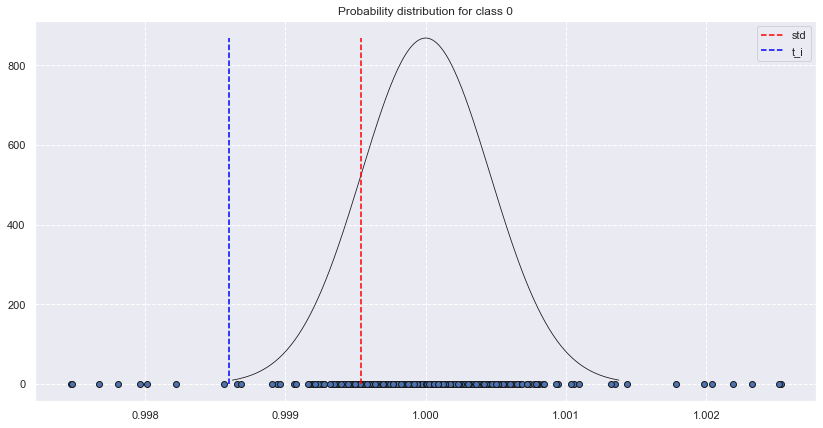

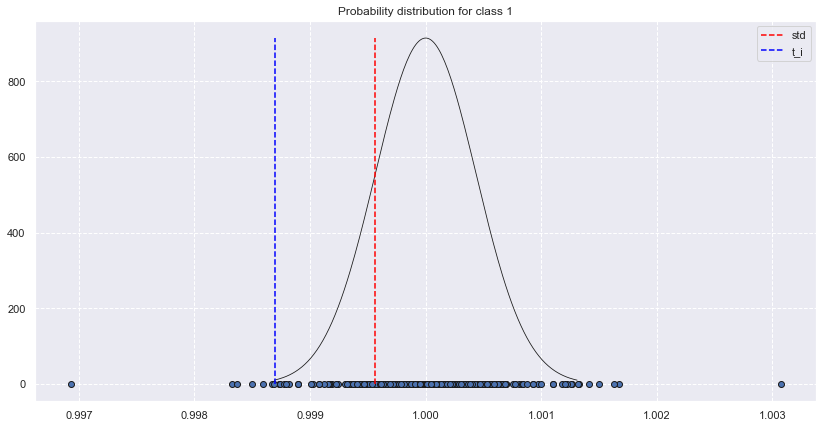

In [11]:
for i in range(y_proba_pred.shape[1]):
    viz_prob_distribution(i)

In [12]:
print(class_thresholds)

[0.9986 0.9987]


# Make Prediction With Rejection Capabilities 

In [13]:
def accept_reject_prediction(prob_list):
    if np.all(prob_list < class_thresholds):
        return 'UNKWNOWN'
    else:
        return int(np.argmax(prob_list))

In [14]:
y_pred_proba = pd.DataFrame(clf.predict_proba(df[['x1', 'x2']]))
df['prediction'] = y_pred_proba.apply(accept_reject_prediction, axis=1)
df['prediction'] = df['prediction'].astype(str)
df = df.sort_values(by='prediction', ascending=True)
df.sample(5, random_state=1)

,x1,x2,class,prediction,color
384,2.448498,5.047816,1,1,green
466,6.734900,-6.922384,0,UNKWNOWN,blue
633,3.018340,5.385014,1,1,green
552,4.126983,4.435821,1,1,green
752,3.408694,-9.044420,0,0,blue


<AxesSubplot:xlabel='x1', ylabel='x2'>

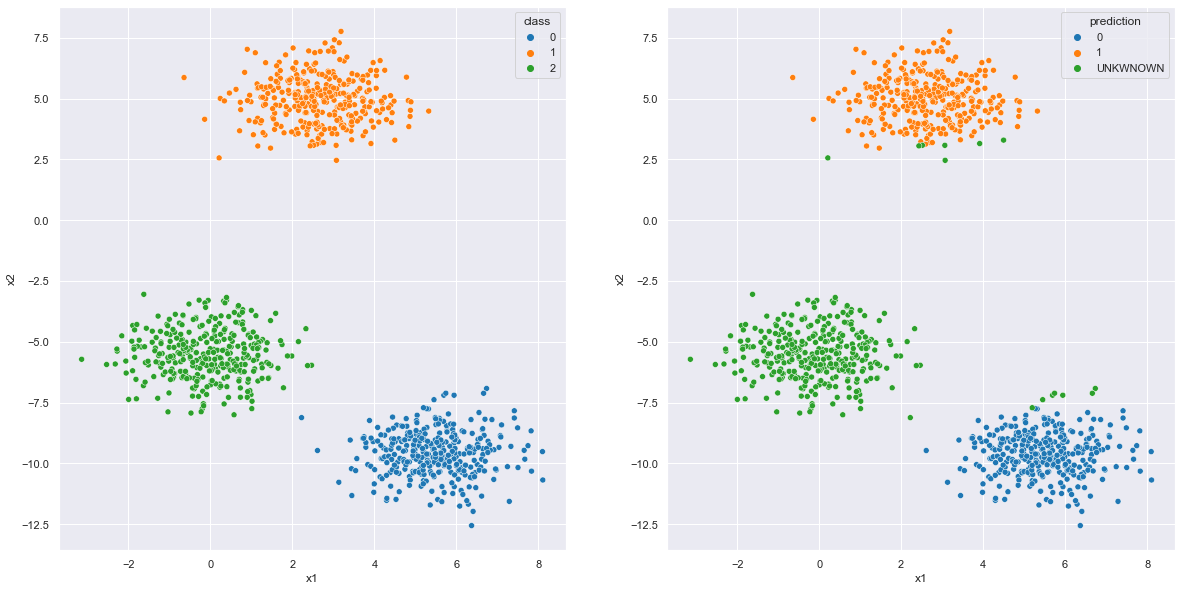

In [15]:
fix, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.scatterplot(df["x1"], df["x2"], hue=df["class"], palette="tab10", ax=axs[0])
sns.scatterplot(
    df["x1"],
    df["x2"],
    hue=df["prediction"],
    palette="tab10",
    ax=axs[1],
)